# Лабораторная работа №6 (Проведение исследований с моделями классификации)

## 1. Выбор начальных условий

В качестве датасета для данной лаборатороной работы я выбрал классификацию пневмонии по [рентгеновскому снимку лёгких](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)

Решение данной задачи имеет прикладное значение в первичной постановке диагноза и валидации медицинских решений

В качестве метрик для данной задачи я решил выбрать **Accuracy**, **Precision**, **Recall** и **F1**. Такие метрики позволяют оценить точность модели и количество ложных срабатываний

Подключим необходимые библиотеки в том числе и torchvision для обучения модели

In [2]:
import os
import copy
import time
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import (
    resnet18, ResNet18_Weights,
    densenet121, DenseNet121_Weights,
    vit_b_16, ViT_B_16_Weights
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 2. Создание бейзлайна и оценка качества
## 2.a. Обучение моделей (CNN и ViT) из torchvision на выбранном наборе данных

Загрузим датасет из Kaggle

In [3]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


Проставим пути для тестовой, валидационной и тестовой выборки

In [4]:
train_dir = path + '/chest_xray/train'
val_dir   = path + '/chest_xray/val'
test_dir  = path + '/chest_xray/test'

Нормализиуем наш датасет и преобразуем к размеру нужному для входа модели

In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_tfms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

Загрузим наши датасеты с помощью **DataLoader**

In [6]:
train_ds = ImageFolder(train_dir, transform=train_tfms)
val_ds   = ImageFolder(val_dir,   transform=val_tfms)
test_ds  = ImageFolder(test_dir,  transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

Выведем наши классы для датасетов (В нашем случае это наличие и отсутствие пневомнии)

In [7]:
print("Найдены классы:", train_ds.dataset.classes
      if hasattr(train_ds, "dataset") else train_ds.classes)

Найдены классы: ['NORMAL', 'PNEUMONIA']


Напиши функции для тренировки и оценки модели.
Если есть возможность подключить GPU для вычисления, то загружаем данные туда
Обучением сделаем по эпохам
В функции оценки модели будем получить 4 метрики, которые мы определили в начале работы

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, loader, optimizer, criterion):
    model.train(); running = 0.
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward(); optimizer.step()
        running += loss.item() * x.size(0)
    return running / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval(); y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        y_pred.extend(logits.argmax(1).cpu().numpy())
        y_true.extend(y.numpy())
    acc  = accuracy_score (y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary')
    rec  = recall_score   (y_true, y_pred, average='binary')
    f1   = f1_score       (y_true, y_pred, average='binary')
    return acc, prec, rec, f1

Напишем функцию обченияя модели. Будем параметризовать её модель, эпохами и скоростью обучения. Будем сохранять модель с лучшим accuracy. В конце считаем метрики нашей модели на тестовой выборке и сохраняем для дальнейшего сравнения

Загружаем 2 модели: ResNet18 - CNN модель и ViT - Визуальный трансформер. Согласуем их входные и выходные слои с условиями нашей задачи (бинарная классификация пневмнонии) и запустим процесс обучения. Визуализация процесса будет проходить с помощью библиотеки tqdm

In [ ]:
def finetune(model, epochs=5, lr=1e-3, save_as="tmp.pt"):
    model.to(device)
    crit = nn.CrossEntropyLoss()
    opt  = optim.Adam(model.parameters(), lr=lr)
    best_acc = 0
    for ep in range(epochs):
        loss = train_epoch(model, train_loader, opt, crit)
        acc, p, r, f1 = evaluate(model, val_loader)
        print(f"Ep{ep+1}/{epochs}  loss={loss:.3f}  val_acc={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_as)
    model.load_state_dict(torch.load(save_as))
    return evaluate(model, test_loader)

results = {}

resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
results['ResNet18'] = finetune(resnet, save_as="resnet18.pt")

vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
vit.heads.head = nn.Linear(vit.heads.head.in_features, 2)
results['ViT_B_16'] = finetune(vit, lr=1e-4, epochs=6, save_as="vit_b16.pt")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


Ep1/5  loss=0.161  val_acc=0.8125


Ep2/5  loss=0.091  val_acc=0.8750


Ep3/5  loss=0.089  val_acc=0.8125


Ep4/5  loss=0.081  val_acc=0.6875


Ep5/5  loss=0.074  val_acc=0.7500


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 194MB/s]


Ep1/6  loss=0.166  val_acc=0.8750


Ep2/6  loss=0.091  val_acc=0.9375


Ep3/6  loss=0.065  val_acc=0.8750


Ep4/6  loss=0.070  val_acc=0.8125


Ep5/6  loss=0.051  val_acc=0.8750


Ep6/6  loss=0.052  val_acc=0.6875


Выведем итоговые метрики в формате Markdown таблицы. Используем библиотеку IPython

In [ ]:
from IPython.display import Markdown, display

table_md = f"""
| Модель       | Accuracy | Precision | Recall | F1  |
|--------------|---------:|----------:|-------:|----:|
| ResNet18     | {results['ResNet18'][0]:.3f} | {results['ResNet18'][1]:.3f} | {results['ResNet18'][2]:.3f} | {results['ResNet18'][3]:.3f} |
| ViT_B_16     | {results['ViT_B_16'][0]:.3f} | {results['ViT_B_16'][1]:.3f} | {results['ViT_B_16'][2]:.3f} | {results['ViT_B_16'][3]:.3f} |
"""

display(Markdown(table_md))


| Модель       | Accuracy | Precision | Recall | F1  |
|--------------|---------:|----------:|-------:|----:|
| ResNet18     | 0.875 | 0.856 | 0.962 | 0.906 |
| ViT_B_16     | 0.912 | 0.900 | 0.967 | 0.932 |


## 2.b.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных

Опираясь на данные выше, можно сказать, что трансформерная архитектура справилась с поставленной задачей лучше, чём сверточная. Значение Accuracy перевалило за 0.9, что говорит о высокой точности модели. Также метрика F1 сильно превышает значение для свёрточной модели

Попробуем теперь использовать модель
Загрузим из тестовой выборки изображение с нормальными и больными лёгкими и посмотрим на вывод моделей

In [32]:
from PIL import Image
import os
import torch
import torch.nn.functional as F
from IPython.display import display, Markdown

def predict_image(models: dict, image_path: str, transform, class_names: list, device: torch.device):
    image = Image.open(image_path).convert("RGB")
    display(image)

    input_tensor = transform(image).unsqueeze(0).to(device)

    results = {}
    with torch.no_grad():
        for name, model in models.items():
            model.eval()
            model.to(device)
            outputs = model(input_tensor)
            probs = F.softmax(outputs, dim=1)
            prob, pred = probs.max(dim=1)
            results[name] = {
                "label": class_names[pred.item()],
                "probability": prob.item()
            }

    md  = "| Модель    | Предсказание      | Вероятность |\n"
    md += "|-----------|-------------------|------------:|\n"
    for name, res in results.items():
        md += f"| {name:<9} | {res['label']:<17} | {res['probability']*100:>7.2f}% |\n"
    display(Markdown(md))

    return results

=== Пример: здоровые лёгкие (NORMAL) ===


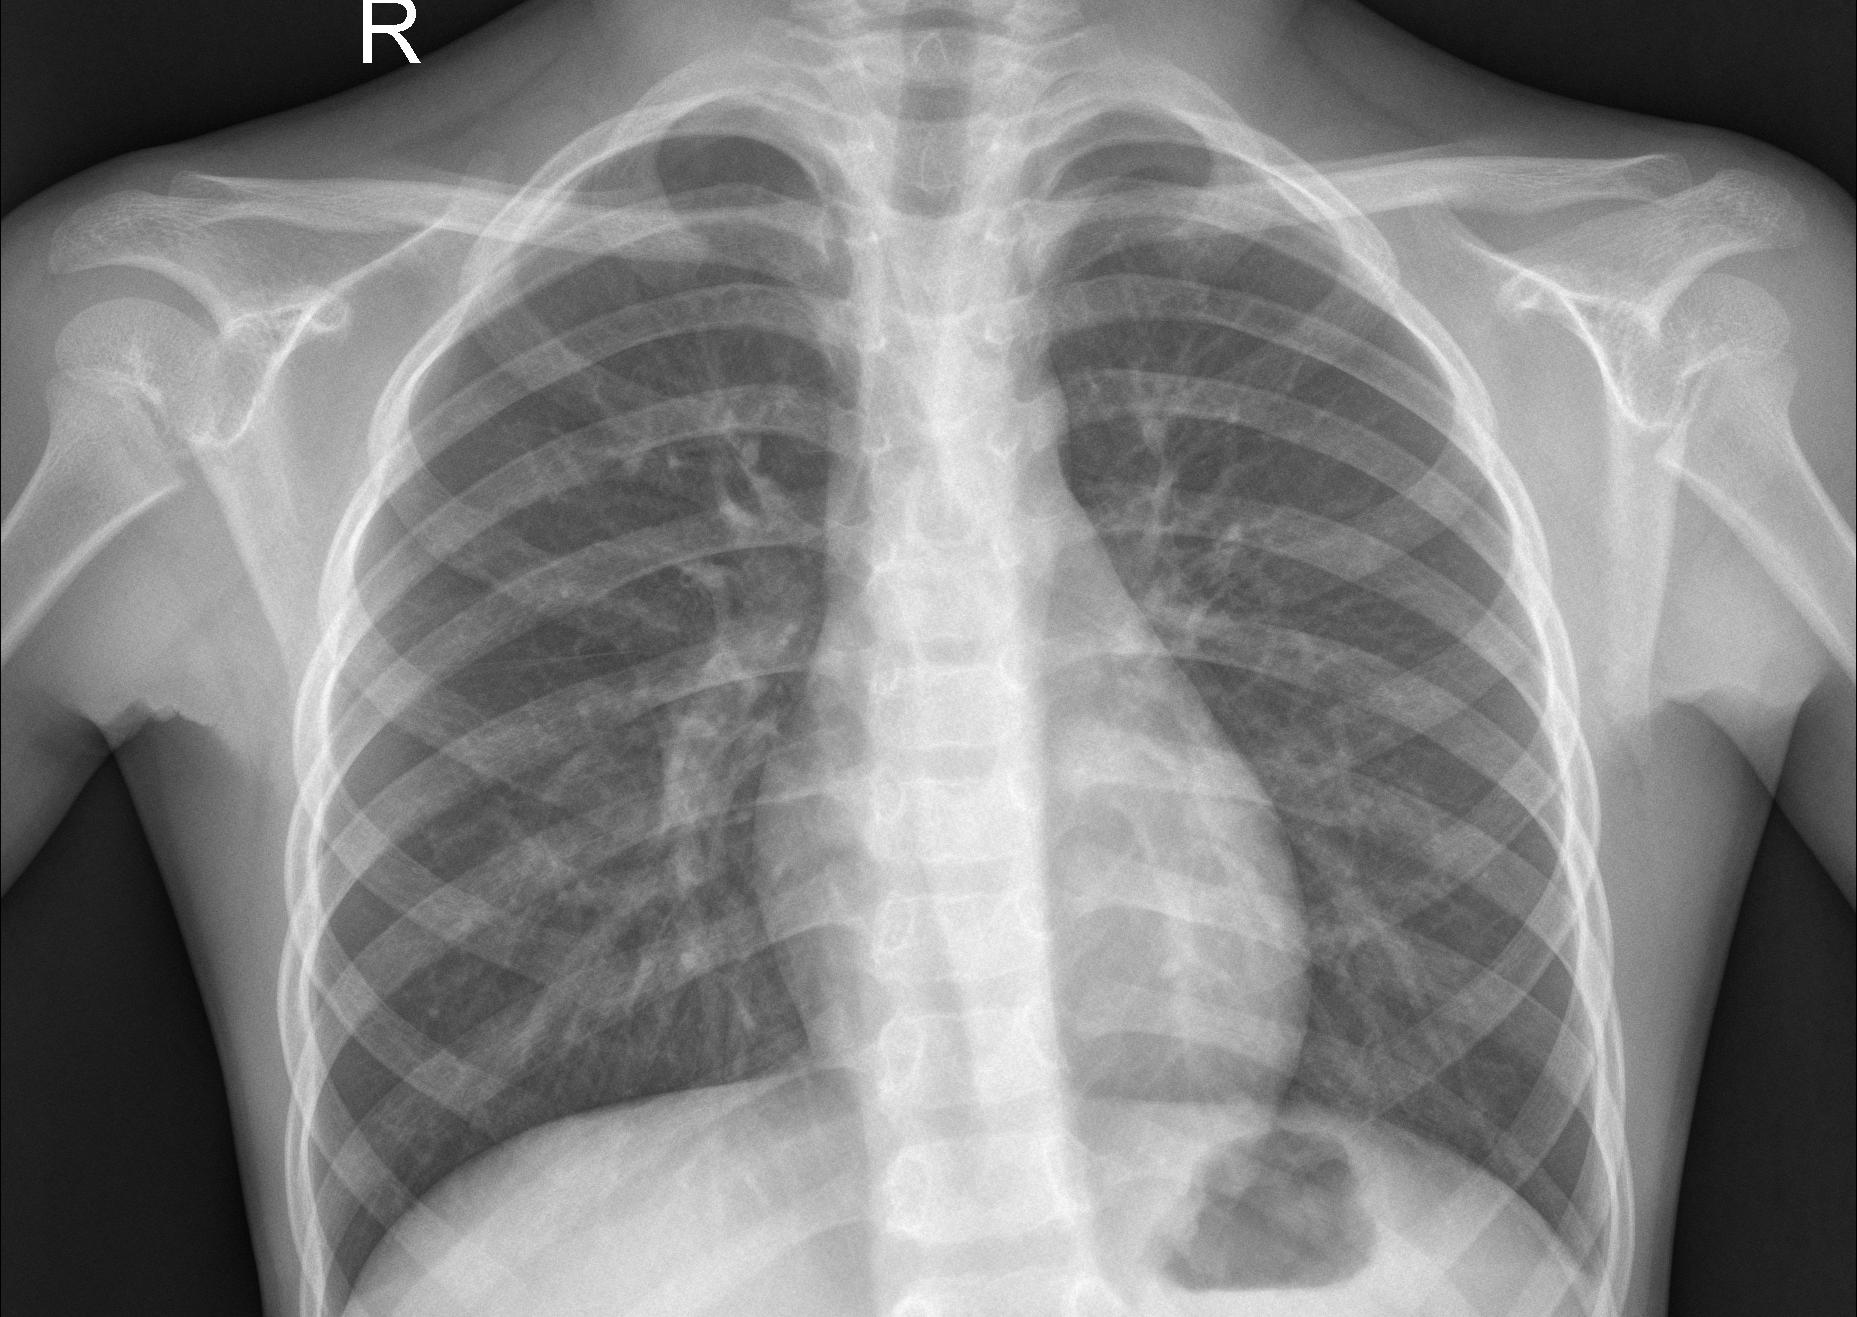

| Модель    | Предсказание      | Вероятность |
|-----------|-------------------|------------:|
| ResNet18  | NORMAL            |   75.24% |
| ViT_B_16  | NORMAL            |   90.18% |



=== Пример: пневмония (PNEUMONIA) ===


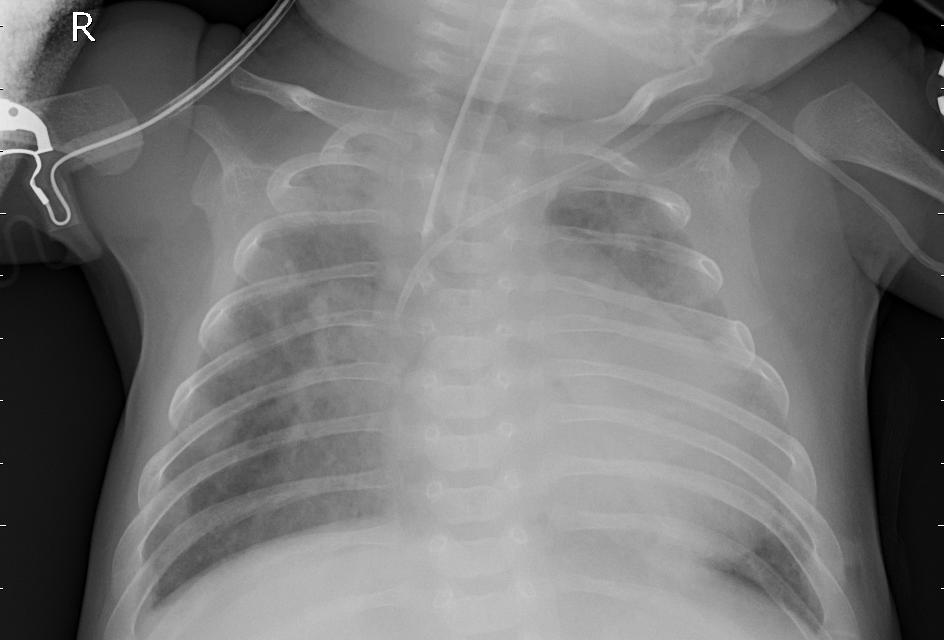

| Модель    | Предсказание      | Вероятность |
|-----------|-------------------|------------:|
| ResNet18  | PNEUMONIA         |   99.99% |
| ViT_B_16  | PNEUMONIA         |   99.86% |


In [ ]:
models = {
    "ResNet18": resnet,
    "ViT_B_16": vit
}

class_names = train_ds.dataset.classes if hasattr(train_ds, "dataset") else train_ds.classes

DATA_ROOT = path + "/chest_xray"
image_normal = os.path.join(DATA_ROOT, "test", "NORMAL", "IM-0001-0001.jpeg")
image_pneumonia = os.path.join(DATA_ROOT, "test", "PNEUMONIA", "person1_virus_6.jpeg")

print("=== Пример: здоровые лёгкие (NORMAL) ===")
predictions_normal = predict_image(models, image_normal, val_tfms, class_names, device)

print("\n=== Пример: пневмония (PNEUMONIA) ===")
predictions_pneumonia = predict_image(models, image_pneumonia, val_tfms, class_names, device)

Обе модели справилис с поставленной задачей правильно, однако трансформерная модель показала себя лучше в определении здоровых лёгких, что говорит о меньшей вероятности ложных срабатываний

# 3. Улучшение бейзлайна
## 3.a. Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)

В тоже время аугментация датасета изменной контрастностью и насыщенностью поможет может помочь расширить точность, т.к. снимки при проявлени обладают разной яркостью.

Затирание различных участков изображения поможет модели лучше сфокусироваться на пораженных участках лёгких.

Также может помочь использование шедулеров скорости обучения, которая будет уменьшать это значение если не происходит значительное изменение параметров


In [11]:
import torchvision.transforms as T

# Бейзлайн базовый (ротации и перевороты)
baseline_tfms = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Аугментация с помощью изменения яркости, контрастности и экспозиции
cj_tfms = T.Compose([
    T.Resize((224,224)),
    T.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Предыдущие изменения и вырезания областей
cj_re_tfms = T.Compose([
    T.Resize((224,224)),
    T.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    T.RandomErasing(p=0.5, scale=(0.02,0.15))
])

Запустим эксперементы на модели ResNet. И выберем бейзлайн с более лучшим accuracy для дальнейшего обучения моделей

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

def run_experiment(transform, use_scheduler=False, lr=1e-3, epochs=5):
    train_ds = ImageFolder(train_dir, transform=transform)
    val_ds   = ImageFolder(val_dir,   transform=val_tfms)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)

    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.to(device)

    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=2) if use_scheduler else None

    best_acc = 0.0
    for ep in range(epochs):
        model.train()
        for x,y in tqdm(train_loader, leave=False):
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward(); opt.step()
        model.eval()
        all_pred, all_true = [], []
        with torch.no_grad():
            for x,y in val_loader:
                x = x.to(device)
                logits = model(x)
                all_pred.extend(logits.argmax(1).cpu().numpy())
                all_true.extend(y.numpy())
        acc = accuracy_score(all_true, all_pred)
        if sched: sched.step(acc)
        best_acc = max(best_acc, acc)
    return best_acc

configs = [
    ("baseline",    baseline_tfms,    False, 1e-3),
    ("color_jitter",cj_tfms,          False, 1e-3),
    ("cj_erasing",  cj_re_tfms,       False, 1e-3),
    ("cj_sched",    cj_tfms,          True,  1e-4),
]

results_exp = {}
for name, tfm, sched, lr in configs:
    print(f"=== {name} ===")
    acc = run_experiment(tfm, use_scheduler=sched, lr=lr, epochs=5)
    results_exp[name] = acc

print("\nРезультаты (val Accuracy):", results_exp)

=== baseline ===


=== color_jitter ===


=== cj_erasing ===


=== cj_sched ===



Результаты (val Accuracy): {'baseline': 1.0, 'color_jitter': 1.0, 'cj_erasing': 0.9375, 'cj_sched': 0.9375}


По результатам исследования различных бейзлайнов, можно сделать вывод, что лучше всего себя показали базовый бейзлайн с ротацией изображений и с аугментацией изменной яркостью. Используем этот бейзлайн для обучения наших моделй, также расширим количество обучающих эпох

Опять загрузим наш датасет, в этот раз к train применим тот пайплайн, который показал наибольшее улучшение в эксперименте

In [12]:
train_ds_imp    = ImageFolder(train_dir, transform=cj_tfms)
train_loader_imp= DataLoader(train_ds_imp, batch_size=32, shuffle=True,  num_workers=2)
val_ds          = ImageFolder(val_dir,   transform=val_tfms)
val_loader      = DataLoader(val_ds,       batch_size=32, shuffle=False, num_workers=2)
test_ds         = ImageFolder(test_dir,  transform=val_tfms)
test_loader     = DataLoader(test_ds,      batch_size=32, shuffle=False, num_workers=2)

Запустим новый процесс обучения с учётом улучшенного пайплайна на тех же моделях. При этом увеличим количество эпох. Добавим вывод промежуточных метрик на всех эпохах обучения

In [ ]:
def train_improved(model, train_loader, val_loader, lr=1e-4, epochs=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)

        acc, prec, rec, f1 = evaluate(model, val_loader)
        print(f"Epoch {epoch}/{epochs} — "
              f"Train Loss: {train_loss:.4f}  "
              f"Val Acc: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_weights = model.state_dict()

    model.load_state_dict(best_weights)
    return model

improved_models = {}
for name, constructor, weights in [
    ("ResNet18",    resnet18,    ResNet18_Weights.IMAGENET1K_V1),
    ("ViT_B_16", vit_b_16, ViT_B_16_Weights.IMAGENET1K_V1),
]:
    print(f"\n=== Training improved {name} ===")
    model = constructor(weights=weights)
    if name == "ResNet18":
        model.fc = nn.Linear(model.fc.in_features, 2)
    else:
        model.heads.head = nn.Linear(model.heads.head.in_features, 2)
    improved_models[name] = train_improved(
        model,
        train_loader_imp,
        val_loader,
        lr=1e-4,
        epochs=10
    )


=== Training improved ResNet18 ===


Epoch 1/10 — Train Loss: 0.1334  Val Acc: 0.8125, Precision: 0.7273, Recall: 1.0000, F1: 0.8421


Epoch 2/10 — Train Loss: 0.0645  Val Acc: 0.8750, Precision: 0.8000, Recall: 1.0000, F1: 0.8889


Epoch 3/10 — Train Loss: 0.0569  Val Acc: 0.9375, Precision: 0.8889, Recall: 1.0000, F1: 0.9412


Epoch 4/10 — Train Loss: 0.0445  Val Acc: 0.5625, Precision: 0.5333, Recall: 1.0000, F1: 0.6957


Epoch 5/10 — Train Loss: 0.0405  Val Acc: 0.8750, Precision: 0.8000, Recall: 1.0000, F1: 0.8889


Epoch 6/10 — Train Loss: 0.0376  Val Acc: 0.6875, Precision: 0.6154, Recall: 1.0000, F1: 0.7619


Epoch 7/10 — Train Loss: 0.0328  Val Acc: 0.9375, Precision: 0.8889, Recall: 1.0000, F1: 0.9412


Epoch 8/10 — Train Loss: 0.0291  Val Acc: 0.6875, Precision: 0.6154, Recall: 1.0000, F1: 0.7619


Epoch 9/10 — Train Loss: 0.0334  Val Acc: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 10/10 — Train Loss: 0.0191  Val Acc: 0.8750, Precision: 0.8000, Recall: 1.0000, F1: 0.8889

=== Training improved ViT_B_16 ===


Epoch 1/10 — Train Loss: 0.2013  Val Acc: 0.8125, Precision: 0.7273, Recall: 1.0000, F1: 0.8421


Epoch 2/10 — Train Loss: 0.0986  Val Acc: 0.9375, Precision: 0.8889, Recall: 1.0000, F1: 0.9412


Epoch 3/10 — Train Loss: 0.0757  Val Acc: 0.9375, Precision: 0.8889, Recall: 1.0000, F1: 0.9412


Epoch 4/10 — Train Loss: 0.0817  Val Acc: 0.8750, Precision: 0.8000, Recall: 1.0000, F1: 0.8889


Epoch 5/10 — Train Loss: 0.0585  Val Acc: 0.6875, Precision: 0.6154, Recall: 1.0000, F1: 0.7619


Epoch 6/10 — Train Loss: 0.0628  Val Acc: 0.6875, Precision: 0.6154, Recall: 1.0000, F1: 0.7619


Epoch 7/10 — Train Loss: 0.0532  Val Acc: 0.8750, Precision: 0.8000, Recall: 1.0000, F1: 0.8889


Epoch 8/10 — Train Loss: 0.0597  Val Acc: 0.7500, Precision: 0.6667, Recall: 1.0000, F1: 0.8000


Epoch 9/10 — Train Loss: 0.0495  Val Acc: 0.8750, Precision: 0.8000, Recall: 1.0000, F1: 0.8889


Epoch 10/10 — Train Loss: 0.0688  Val Acc: 0.7500, Precision: 0.6667, Recall: 1.0000, F1: 0.8000


In [ ]:
impr_results = {}
for name, model in improved_models.items():
    acc, prec, rec, f1 = evaluate(model, test_loader)
    impr_results[name] = (acc, prec, rec, f1)
    print(f"{name} "
          f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, "
          f"Recall: {rec:.4f}, F1: {f1:.4f}")

ResNet18 Accuracy: 0.7933, Precision: 0.7514, Recall: 1.0000, F1: 0.8581
ViT_B_16 Accuracy: 0.8333, Precision: 0.7918, Recall: 0.9949, F1: 0.8818


Анализируя полученные результаты можно сделать вывод, что общая точность модели снизилась. Однако метрика Recall преодолела 0.99. На самом деле модель стала чаще выставлять даже здоровым людям пневмонию. С одной стороны рост такой метрики исключает возможность пропуска больных людей, с другой увеличивает число ложноположительных срабатываний. Причиной такого изменения метрик могло служить аугментирование датасета новыми данными, что увеличило число снимков с пневмонией по сравнению со здоровыми

# 4.	Имплементация алгоритма машинного обучения

Реализуем свой собственный алгоритм Свёрточной нейронной сети используя библиотеку torch

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import pandas as pd
from tqdm import tqdm

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64 * 28 * 28, num_classes)
    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        return self.fc(x)

Добавим лоадеры для датасета

In [22]:
train_ds_base = ImageFolder(train_dir, transform=baseline_tfms)
val_ds_base   = ImageFolder(val_dir,   transform=baseline_tfms)
test_ds       = ImageFolder(test_dir,  transform=baseline_tfms)

train_loader_base = DataLoader(train_ds_base, batch_size=32, shuffle=True,  num_workers=2)
val_loader_base   = DataLoader(val_ds_base,   batch_size=32, shuffle=False, num_workers=2)
test_loader       = DataLoader(test_ds,        batch_size=32, shuffle=False, num_workers=2)

Создадим нашу модель и положим в устройство (GPU или CPU) объявим параметры обучения и обучим на 5 эпохах

In [23]:
model_base = SimpleCNN(num_classes=2).to(device)
optimizer = optim.Adam(model_base.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    loss = train_epoch(model_base, train_loader_base, optimizer, criterion)
acc_base, prec_base, rec_base, f1_base = evaluate(model_base, test_loader)

Проделаем аналогичную процедуру для улучшенного бейзлайна

In [24]:
train_ds_imp = ImageFolder(train_dir, transform=cj_tfms)
val_ds_imp   = ImageFolder(val_dir,   transform=cj_tfms)

train_loader_imp = DataLoader(train_ds_imp, batch_size=32, shuffle=True,  num_workers=2)
val_loader_imp   = DataLoader(val_ds_imp,   batch_size=32, shuffle=False, num_workers=2)

Поставим модель с улучшенным бейзлайном на обучение на 10 эпохах

In [25]:
model_imp = SimpleCNN(num_classes=2).to(device)
optimizer_imp = optim.Adam(model_imp.parameters(), lr=1e-4)

for epoch in range(10):
    loss = train_epoch(model_imp, train_loader_imp, optimizer_imp, criterion)
acc_imp, prec_imp, rec_imp, f1_imp = evaluate(model_imp, test_loader)

In [26]:
from IPython.display import Markdown, display

table_md_base = f"""
**CNN имплементация**

| Модель       | Accuracy | Precision | Recall | F1  |
|--------------|---------:|----------:|-------:|----:|
| Базовый Baseline | {acc_base:.3f} | {prec_base:.3f} | {rec_base:.3f} | {f1_base:.3f} |
| Улучшенный Baseline | {acc_imp:.3f} | {prec_imp:.3f} | {rec_imp:.3f} | {f1_imp:.3f} |
"""
display(Markdown(table_md_base))


**CNN имплементация**

| Модель       | Accuracy | Precision | Recall | F1  |
|--------------|---------:|----------:|-------:|----:|
| Базовый Baseline | 0.739 | 0.707 | 0.995 | 0.826 |
| Улучшенный Baseline | 0.748 | 0.716 | 0.990 | 0.831 |


Полученные модели CNN все же несколько уступают модель из torchvision, но все же показывают достаточно высокие метрики (в частности очень важный параметр Recall для нашей задачи) и имеют место быть. В моей задаче использование аугментирования датасета помогло лучше справиться с задачей

Теперь реализуем собственную модель визуального трансформера. Она получится доасточно упрощенной по сравнению с библиотечной реализацией в связи с достаточно не тривиальной структурой

In [14]:
class SimpleViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, emb_dim=128, depth=6, n_heads=8, mlp_ratio=4, num_classes=2):
        super(SimpleViT, self).__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(3, emb_dim, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads,
                                                   dim_feedforward=emb_dim * mlp_ratio, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Linear(emb_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1,2)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed

        x = self.transformer(x)

        cls_out = x[:,0]
        return self.head(cls_out)


Напишем лоадеры для датасетов для обучения

In [27]:
train_ds_base = ImageFolder(train_dir, transform=baseline_tfms)
val_ds        = ImageFolder(val_dir,   transform=baseline_tfms)
test_ds       = ImageFolder(test_dir,  transform=baseline_tfms)

train_loader_base = DataLoader(train_ds_base, batch_size=32, shuffle=True,  num_workers=2)
val_loader        = DataLoader(val_ds,           batch_size=32, shuffle=False, num_workers=2)
test_loader       = DataLoader(test_ds,          batch_size=32, shuffle=False, num_workers=2)

train_ds_imp = ImageFolder(train_dir, transform=cj_tfms)
train_loader_imp = DataLoader(train_ds_imp, batch_size=32, shuffle=True, num_workers=2)

Напишем функцичю для обучения модели

In [28]:
def train_model(model, train_loader, val_loader, lr=1e-3, epochs=5):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    best_w = None
    for ep in range(1, epochs+1):
        loss = train_epoch(model, train_loader, optimizer, criterion)
        acc, prec, rec, f1 = evaluate(model, val_loader)
        if acc > best_acc:
            best_acc = acc
            best_w = model.state_dict()
    model.load_state_dict(best_w)
    return evaluate(model, test_loader)

Обучим модель на базовом датасете

In [29]:
vit_base = SimpleViT()
res_base_metrics = train_model(vit_base, train_loader_base, val_loader, lr=1e-3, epochs=5)

Обучим модель на улучшенном бейзлайне

In [30]:
vit_imp = SimpleViT()
res_imp_metrics = train_model(vit_imp, train_loader_imp, val_loader, lr=1e-4, epochs=10)

Выведем и провалидируем результаты

In [31]:
models = ['SimpleViT']
baseline_vals = res_base_metrics
improved_vals = res_imp_metrics

table_md = f"""
| Model      | Setup          | Accuracy | Precision | Recall | F1    |
|------------|----------------|---------:|----------:|-------:|------:|
| SimpleViT  | Baseline       | {baseline_vals[0]:.3f} | {baseline_vals[1]:.3f} | {baseline_vals[2]:.3f} | {baseline_vals[3]:.3f} |
| SimpleViT  | Improved (cj)  | {improved_vals[0]:.3f} | {improved_vals[1]:.3f} | {improved_vals[2]:.3f} | {improved_vals[3]:.3f} |
"""

display(Markdown(table_md))


| Model      | Setup          | Accuracy | Precision | Recall | F1    |
|------------|----------------|---------:|----------:|-------:|------:|
| SimpleViT  | Baseline       | 0.732 | 0.708 | 0.972 | 0.819 |
| SimpleViT  | Improved (cj)  | 0.744 | 0.711 | 0.995 | 0.829 |


Полученные модели для визуального трансформера показали также результаты ниже библиотечных моделей, но они находятся все же на достаточно высоком уровне. Использование улучшенного бейзлайна помогло увеличить метрики.

=== Пример: здоровые лёгкие (NORMAL) ===


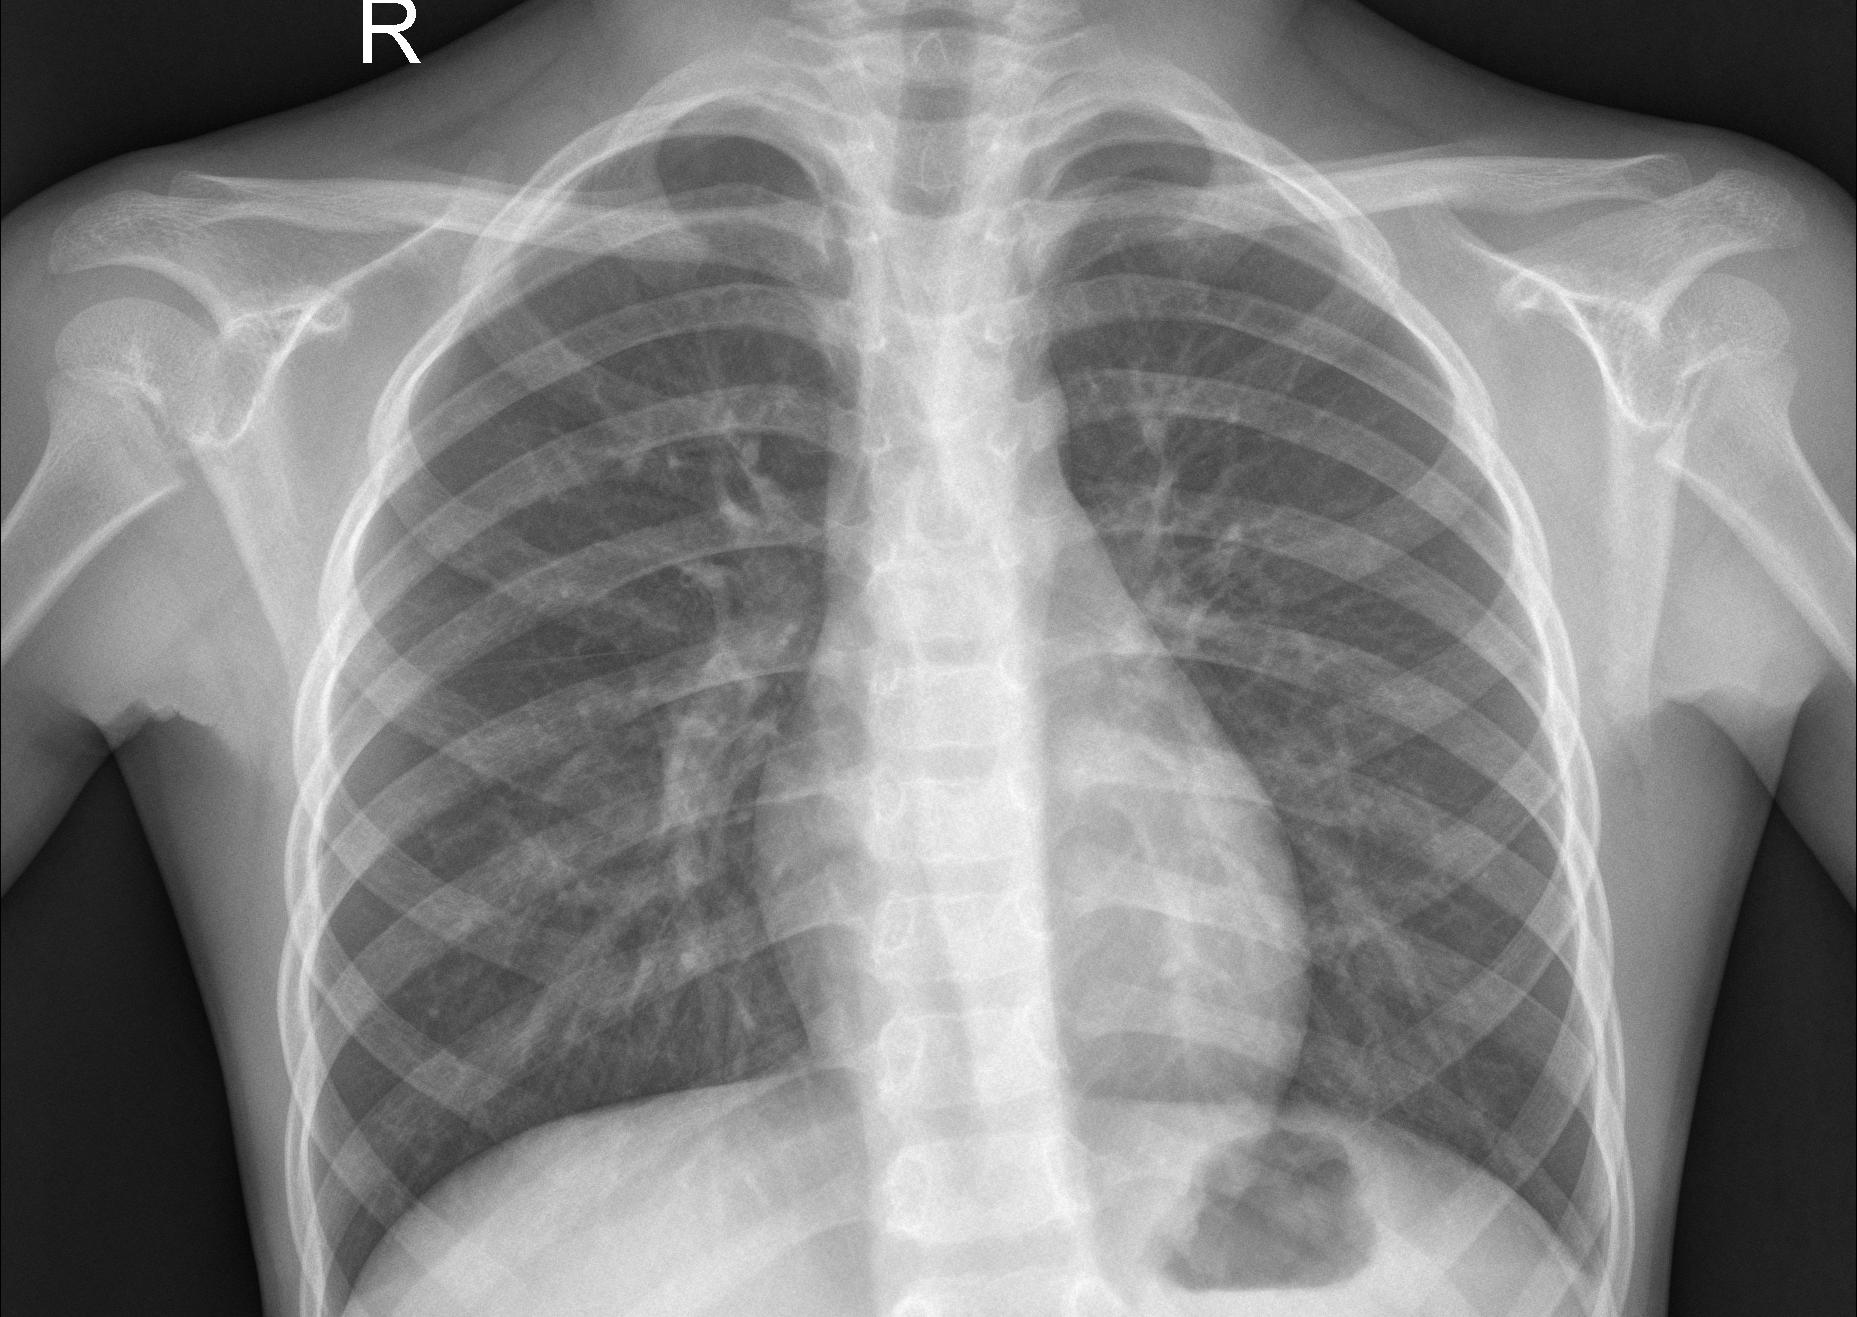

| Модель    | Предсказание      | Вероятность |
|-----------|-------------------|------------:|
| SimpleCNN | NORMAL            |   91.96% |
| SimpleViT | NORMAL            |   70.82% |



=== Пример: пневмония (PNEUMONIA) ===


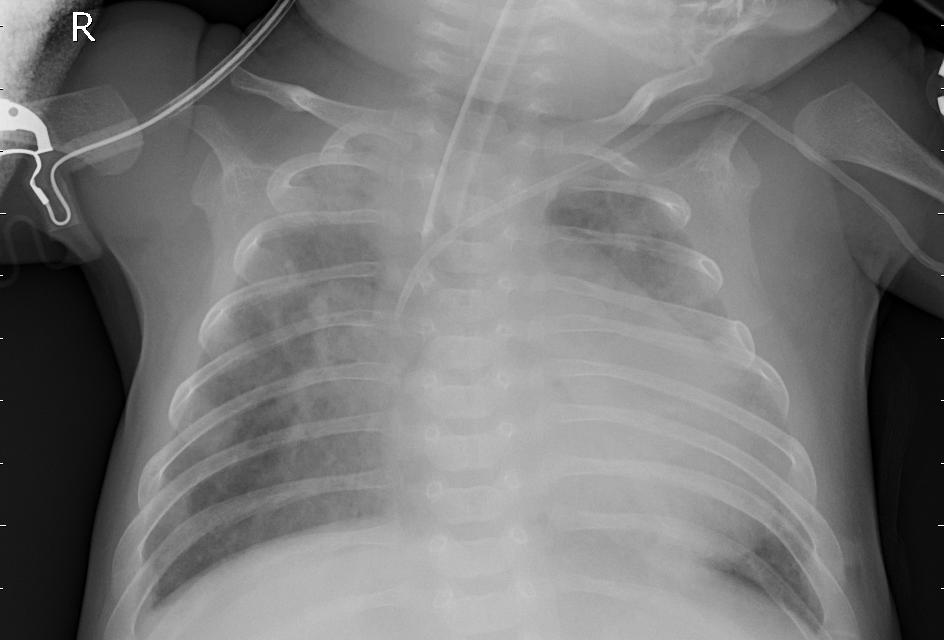

| Модель    | Предсказание      | Вероятность |
|-----------|-------------------|------------:|
| SimpleCNN | PNEUMONIA         |  100.00% |
| SimpleViT | PNEUMONIA         |   99.47% |


In [34]:
models = {
    "SimpleCNN": model_imp,
    "SimpleViT": vit_imp
}

class_names = train_ds.dataset.classes if hasattr(train_ds, "dataset") else train_ds.classes

DATA_ROOT = path + "/chest_xray"
image_normal = os.path.join(DATA_ROOT, "test", "NORMAL", "IM-0001-0001.jpeg")
image_pneumonia = os.path.join(DATA_ROOT, "test", "PNEUMONIA", "person1_virus_6.jpeg")

print("=== Пример: здоровые лёгкие (NORMAL) ===")
predictions_normal = predict_image(models, image_normal, val_tfms, class_names, device)

print("\n=== Пример: пневмония (PNEUMONIA) ===")
predictions_pneumonia = predict_image(models, image_pneumonia, val_tfms, class_names, device)

На примерах видно, что модель CNN опять показало лучший результат, чем визуальный трансформер. Возможно это связано с необходимостью более точной настройки трансформерной архитектуры и более долгим процессом обучения

# Итоговые результаты

| Model                                       | Accuracy | Precision | Recall | F1    |
| ------------------------------------------- | -------- | --------- | ------ | ----- |
| ResNet                                      | 0.875    | 0.856     | 0.962  | 0.906 |
| ViT                                         | 0.912    | 0.900     | 0.967  | 0.932 |
| ResNet<br>(Улучшенный baseline)             | 0.793    | 0.751     | 1.000  | 0.858 |
| ViT<br>(Улучшенный baseline)                | 0.833    | 0.791     | 0.994  | 0.881 |
| CNN-Implementation                          | 0.739    | 0.707     | 0.995  | 0.826 |
| ViT-Implementation                          | 0.732    | 0.708     | 0.972  | 0.819 |
| CNN-Implementation <br> (Улучшенный baseline)   | 0.748    | 0.716     | 0.990  | 0.831 |
| ViT-Implementation<br>(Улучшенный baseline) | 0.744    | 0.711     | 0.995  | 0.829 |

В результате данной лабораторной работы были исследованы модели CNN и ViT для классификации изображений. В ходе работы наиболее высокие метрики показала модель на базе CNN, причем как в библиотечной вариации, так и в собственной вариации. Реализация своих алгоритмов показала себя немного хуже стандартных, что связано со сложностью моделей и внутренней оптимизацией таких структур. Были продемонстрированы примеры работы всех алгоритмов, которые имееют применение в практической задаче выявления пневмонии